In [ ]:
import os
from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

from fastai.tabular.all import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG

# Change this path to adapt to where you downloaded the data
BASE_PATH = Path("/storage/geolifeclef-2021/")
DATA_PATH = BASE_PATH / "data"

# Create the path to save submission files
SUBMISSION_PATH = Path("submissions")
os.makedirs(SUBMISSION_PATH, exist_ok=True)

In [ ]:
#from dask.distributed import Client
#from dask import dataframe as dd
#client = Client()
#client

In [ ]:
from GLC.metrics import top_30_error_rate
from GLC.metrics import top_k_error_rate_from_sets
from GLC.metrics import predict_top_30_set, predict_top_k_set

from sklearn.ensemble import RandomForestClassifier

# Observation data loading

We first need to load the observation data:


In [ ]:
def get_observations(data_path):
    df_fr = pd.read_csv(data_path / "observations" / "observations_fr_train.csv",
                        sep=";", index_col="observation_id")
    df_us = pd.read_csv(data_path / "observations" / "observations_us_train.csv",
                        sep=";", index_col="observation_id")
    
    df = pd.concat((df_fr, df_us))
    
    return df

def get_test_observations(data_path):
    df_fr_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";",
                             index_col="observation_id")
    df_us_test = pd.read_csv(DATA_PATH / "observations" / "observations_us_test.csv", sep=";",
                             index_col="observation_id")
    
    df_test = pd.concat((df_fr_test, df_us_test))
    
    return df_test

Then, we retrieve the train/val split provided:

In [ ]:
df = get_observations(DATA_PATH)

obs_id_train = df.index[df["subset"] == "train"].values
obs_id_val = df.index[df["subset"] == "val"].values

y_train = df.loc[obs_id_train]["species_id"].values
y_val = df.loc[obs_id_val]["species_id"].values

n_val = len(obs_id_val)
print("Validation set size: {} ({:.1%} of train observations)".format(n_val, n_val / len(df)))

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Validation set size: 45446 (2.4% of train observations)




We also load the observation data for the test set:


In [ ]:
df_test = get_test_observations(DATA_PATH)
obs_id_test = df_test.index

print("Number of observations for testing: {}".format(len(df_test)))

df_test.head()

Number of observations for testing: 42405


,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459
10222322,46.938450,5.298678
10241950,45.017433,0.960736


For submissions, we also need the following mapping to correct a slight misalignment in the test observation ids:

In [ ]:
df_test_obs_id_mapping = pd.read_csv(BASE_PATH / "test_observation_ids_mapping.csv", sep=";")
df_test_obs_id_mapping.head()

,observation_id,Id
0,10782781,10782781
1,10364138,10364138
2,10692017,10692017
3,10222322,10222322
4,10241950,10241950



# Sample submission file

In this section, we will demonstrate how to generate the sample submission file provided.

To do so, we will use this function:


In [ ]:
def generate_submission_file(filename, corrected_observation_ids, s_pred):
    s_pred = [
        " ".join(map(str, pred_set))
        for pred_set in s_pred
    ]
    
    df = pd.DataFrame({
        "Id": corrected_observation_ids,
        "Predicted": s_pred
    })
    df.to_csv(filename, index=False)

# Random forest on environmental vectors

A classical approach in ecology is to train Random Forests on environmental vectors.

We show here how to do so using scikit-learn.

We start by loading the environmental vectors:

In [ ]:
df_env = pd.read_csv(DATA_PATH / "pre-extracted" / "environmental_vectors.csv", sep=";", index_col="observation_id")

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
df_env.head(3)

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_18,bio_19,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt
observation_id,,,,,,,,,,,,,,,,,,,,,
10000000,1.420833,6.908333,29.272598,614.1493,15.1,-8.5,23.600000,-1.000000,9.183333,9.466667,...,248.0,358.0,2082.0,988.0,29.0,13.0,63.0,62.0,34.0,53.0
10000001,8.837500,9.858334,37.771393,586.8139,23.8,-2.3,26.099998,6.016667,16.383333,16.383333,...,226.0,288.0,1816.0,1142.0,20.0,22.0,39.0,58.0,41.0,36.0
10000002,6.241667,8.350000,32.239384,632.8609,21.0,-4.9,25.900000,3.033333,14.200000,14.200000,...,268.0,317.0,1346.0,1075.0,29.0,22.0,54.0,59.0,40.0,38.0


In [ ]:
#X_train = df_env.loc[obs_id_train].values
#X_val = df_env.loc[obs_id_val].values
#X_test = df_env.loc[obs_id_test].values

## Data pre-processing

Then, we need to handle properly the missing values.

For instance, using [SimpleImputer]:


In [ ]:
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(missing_values=np.nan, strategy="mean")
#imp.fit(X_train)

#X_train = imp.transform(X_train)
#X_val = imp.transform(X_val)
#X_test = imp.transform(X_test)

In [ ]:
#train_fastai = pd.DataFrame(X_train, columns=df_env.columns)
#train_fastai['spid'] = y_train

In [ ]:
#train_fastai = df.loc[obs_id_train].drop(columns='subset')
#train_fastai = train_fastai.merge(df_env.loc[obs_id_train], on=['observation_id'])

In [ ]:
#train_fastai['species_id'] = train_fastai['species_id'].astype(str)

# Following the Getting started notebook, but changing RF to fastai tabular NN

In [ ]:
# MultiCategoryBlock??

In [ ]:
#value_counts = train_fastai['species_id'].value_counts()
#train_spp = value_counts[:10]

In [ ]:
#train_fastai = train_fastai[train_fastai.species_id.isin(train_spp.index)]

In [ ]:
#train_fastai.drop_duplicates(inplace=True)

In [ ]:
#train_fastai = train_fastai.groupby(list(df_env.columns) + ['latitude', 'longitude'])['species_id'].apply(', '.join).reset_index()

In [ ]:
#cont, cat = cont_cat_split(train_fastai, dep_var='species_id')

In [ ]:
# cont, cat

In [ ]:
#train_fastai[train_fastai.species_id.apply(len) > 6][:1]

In [ ]:
#splits = RandomSplitter(valid_pct=0.1)(range_of(train_fastai))

In [ ]:
#def get_y(r):
#    return r['species_id'].split(',')

In [ ]:
#dblock = DataBlock(get_y=get_y, blocks=[DataBlock, MultiCategoryBlock])

In [ ]:
#dsets = dblock.datasets(train_fastai)

In [ ]:
#dblock.summary(train_fastai)

In [ ]:
#Tabular.transform

In [ ]:
#@MultiCategorize
#def encodes(self, to:Tabular): 
    #to.transform(to.y_names, partial(_apply_cats, {n: self.vocab for n in to.y_names}, 0))
#    return to
  
#@MultiCategorize
#def decodes(self, to:Tabular): 
    #to.transform(to.y_names, partial(_decode_cats, {n: self.vocab for n in to.y_names}))
#    return to

In [ ]:
#MultiCategorize??

In [ ]:
#to = TabularPandas(train_fastai, procs=[Categorify, FillMissing, Normalize],
#                   cont_names = cont,
#                   cat_names=None,
#                   y_names='species_id',
#                   y_block=MultiCategoryBlock,
#                   splits=splits)

In [ ]:
#to['species_id']

In [ ]:
#dls = to.dataloaders(bs=64)

In [ ]:
#to.show(5)

In [ ]:
#dls.show_batch()

In [ ]:
#learn = tabular_learner(dls, metrics=accuracy)

In [ ]:
#min_lr, steep_lr = learn.lr_find()

In [ ]:
#learn.fit_one_cycle(100, steep_lr)

In [ ]:
#learn.show_results()

In [ ]:
#val_fastai = df.loc[obs_id_val].drop(columns=['subset', 'species_id'])
#val_fastai = val_fastai.merge(df_env.loc[obs_id_val], on=['observation_id'])
#val_fastai

In [ ]:
#val_fastai = pd.DataFrame(X_val, columns=df_env.columns)
#val_fastai['spid'] = y_val
#dls_val = learn.dls.test_dl(val_fastai)
#preds, _ = learn.get_preds(dl=dls_val)

In [ ]:
#preds_ids = array([value_counts[:60].index[pred] for pred in predict_top_k_set(preds, 30)])
#score_val = top_k_error_rate_from_sets(y_val, preds_ids)
#print("Top-30 error rate: {:.1%}".format(score_val))

In [ ]:
#test_fastai = pd.DataFrame(X_test, columns=df_env.columns)
#val_fastai['spid'] = y_val
#dls_test = learn.dls.test_dl(test_fastai)
#preds, _ = learn.get_preds(dl=dls_test)
#preds_ids = array([value_counts[:500].index[pred] for pred in predict_top_k_set(preds, 10)])
# Generate the submission file
#generate_submission_file(SUBMISSION_PATH/"fastai_on_environmental_vectors.csv", df_test_obs_id_mapping["Id"], preds_ids)

In [ ]:
#!kaggle competitions submit -c geolifeclef-2021 -f {SUBMISSION_PATH/"fastai_on_environmental_vectors.csv"} -m "fastai 500 submission"

# With fastai FillNull

In [ ]:
# MultiCategorize??

In [ ]:
df['species_id'] = df['species_id'].astype('str')

In [ ]:
data_set = df.merge(df_env, on='observation_id')

In [ ]:
data_set.head(3)

,latitude,longitude,species_id,subset,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,...,bio_18,bio_19,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt
observation_id,,,,,,,,,,,,,,,,,,,,,
10561949,45.705116,1.424622,241,train,11.229167,8.724999,37.286324,556.81506,24.5,1.1,...,211.0,287.0,1678.0,1381.0,13.0,20.0,26.0,58.0,36.0,44.0
10131188,45.146973,6.416794,101,train,4.587500,9.058333,33.302696,664.60220,19.9,-7.3,...,265.0,362.0,1771.0,1219.0,28.0,18.0,49.0,61.0,38.0,45.0
10076047,49.746944,4.686389,38,train,9.670834,8.608334,36.169468,571.84100,23.2,-0.6,...,227.0,244.0,1980.0,1377.0,19.0,29.0,29.0,65.0,46.0,24.0


In [ ]:
data_set.drop_duplicates(inplace=True)

In [ ]:
value_counts = data_set['species_id'].value_counts()

In [ ]:
data_set = data_set[data_set.species_id.isin(value_counts[value_counts > 90].index)]

In [ ]:
vocab = list(data_set.species_id.unique())

In [ ]:
len(vocab)

3313

In [ ]:
# data_set = data_set.groupby(list(df_env.columns) + ['latitude', 'longitude', 'subset'])['species_id'].apply(', '.join).reset_index()

In [ ]:
# data_set[data_set.species_id.apply(len) > 10].head(1)

In [ ]:
y = pd.get_dummies(data_set.species_id)

In [ ]:
# y = y.astype('float')

In [ ]:
data_set = data_set.merge(y, on='observation_id')

In [ ]:
data_set = data_set.drop(columns='species_id')

In [ ]:
del y

In [ ]:
# data_set.to_csv('df_env_obs_500.csv', index=False)

In [ ]:
# del data_set

## Read last dataframe

In [ ]:
# data_set = pd.read_csv('df_env_obs_500.csv')

In [ ]:
# data_set.head().T

In [ ]:
len(data_set)

1453487

In [ ]:
batch_size = 100_000

def group_labels(df, group_cols, batch_size):
    data_set_batches = []

    for b in range(0, len(df), batch_size):
        batch = df[b:(b + batch_size)]
        batch = batch.groupby(group_cols, dropna=False)[vocab].max().reset_index()
        data_set_batches.append(batch)
        print(f'Batch: {b}, size {len(batch)}')
    
    return pd.concat(data_set_batches)

In [ ]:
data_set = data_set.sample(frac = 1)

In [ ]:
data_set = group_labels(data_set,
                        list(df_env.columns) + ['latitude', 'longitude', 'subset'],
                        batch_size)

Batch: 0, size 99519
Batch: 100000, size 99523
Batch: 200000, size 99523
Batch: 300000, size 99538
Batch: 400000, size 99571
Batch: 500000, size 99509
Batch: 600000, size 99510
Batch: 700000, size 99567
Batch: 800000, size 99541
Batch: 900000, size 99503
Batch: 1000000, size 99544
Batch: 1100000, size 99500
Batch: 1200000, size 99539
Batch: 1300000, size 99563
Batch: 1400000, size 53355


In [ ]:
data_set = data_set.sample(frac = 1)

In [ ]:
data_set = group_labels(data_set,
                        list(df_env.columns) + ['latitude', 'longitude', 'subset'],
                        batch_size)

Batch: 0, size 99745
Batch: 100000, size 99708
Batch: 200000, size 99782
Batch: 300000, size 99744
Batch: 400000, size 99733
Batch: 500000, size 99723
Batch: 600000, size 99720
Batch: 700000, size 99719
Batch: 800000, size 99715
Batch: 900000, size 99742
Batch: 1000000, size 99737
Batch: 1100000, size 99735
Batch: 1200000, size 99745
Batch: 1300000, size 99740
Batch: 1400000, size 46738


In [ ]:
data_set = data_set.sample(frac = 1)

In [ ]:
batch_size = 100_000
data_set = group_labels(data_set,
                        list(df_env.columns) + ['latitude', 'longitude', 'subset'],
                        batch_size)

Batch: 0, size 99775
Batch: 100000, size 99765
Batch: 200000, size 99785
Batch: 300000, size 99763
Batch: 400000, size 99771
Batch: 500000, size 99791
Batch: 600000, size 99818
Batch: 700000, size 99793
Batch: 800000, size 99766
Batch: 900000, size 99804
Batch: 1000000, size 99790
Batch: 1100000, size 99785
Batch: 1200000, size 99799
Batch: 1300000, size 99802
Batch: 1400000, size 42979


In [ ]:
len(data_set)

1439986

In [ ]:
#data_set[data_set_grp.bio_1.isnull()]

In [ ]:
# data_set.drop(columns='species_id', inplace=True)
print(f'Max Riqueza: {data_set[vocab].sum(axis=1).max()}')
data_set[data_set[vocab].sum(axis=1) == data_set[vocab].sum(axis=1).max()].T

Max Riqueza: 39


,93468
bio_1,20.8208
bio_2,11.5083
bio_3,39.9595
bio_4,651.618
bio_5,34.5
...,...
16577,0
16801,0
16872,0
11917,0


In [ ]:
# data_set.drop(columns=['subset'], inplace=True)

In [ ]:
# y_names = [sp_id_col for sp_id_col in data_set.columns if 'sp_id_' in sp_id_col]

In [ ]:
# len(y_names)

In [ ]:
# y_names = 'species_id'
cont, cat = cont_cat_split(data_set, dep_var=vocab)

In [ ]:
cat

['subset']

In [ ]:
cont

['bio_1',
 'bio_2',
 'bio_3',
 'bio_4',
 'bio_5',
 'bio_6',
 'bio_7',
 'bio_8',
 'bio_9',
 'bio_10',
 'bio_11',
 'bio_12',
 'bio_13',
 'bio_14',
 'bio_15',
 'bio_16',
 'bio_17',
 'bio_18',
 'bio_19',
 'bdticm',
 'bldfie',
 'cecsol',
 'clyppt',
 'orcdrc',
 'phihox',
 'sltppt',
 'sndppt',
 'latitude',
 'longitude']

In [ ]:
procs = [Categorify, FillMissing, Normalize]

In [ ]:
y_names=vocab

In [ ]:
cond = data_set.subset == 'train'

train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [ ]:
%%time 
to = TabularPandas(data_set,
                   cont_names=cont,
                   cat_names=None,
                   procs=procs,
                   y_names=y_names,
                   y_block=MultiCategoryBlock(encoded=True, vocab=vocab),
                   splits=splits)

CPU times: user 1min 4s, sys: 26.8 s, total: 1min 30s
Wall time: 1min 30s


In [ ]:
len(to.train),len(to.valid)

(1404515, 35471)

In [ ]:
#to.procs[1]

In [ ]:
#to.show()

In [ ]:
get_c(to)

3313

In [ ]:
dls = to.dataloaders(1024)

In [ ]:
learn = tabular_learner(dls, [3000, 2000], metrics=accuracy_multi)

In [ ]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(3, 3)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
    (20): Embedding(3, 3)
    (21): Embedding(3, 3)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
    (24): Embedding(3, 3)
    (25): Embedding(3, 3)
    (26): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=110, out_features=3000, bias=False)
      (1): ReLU(inp

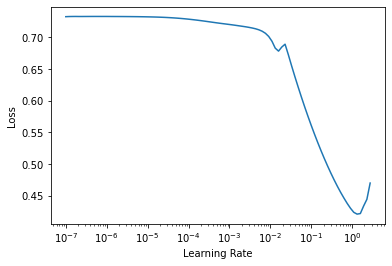

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [ ]:
(lr_min, lr_steep)

(0.13182567358016967, 0.02754228748381138)

In [ ]:
learn.fit_one_cycle(15, lr_steep)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.002262,0.002264,0.999696,02:37
1,0.002221,0.002224,0.999696,02:38
2,0.002204,0.002234,0.999696,02:37
3,0.002181,0.002211,0.999696,02:38
4,0.002169,0.002206,0.999697,02:37
5,0.002155,0.002205,0.999697,02:38
6,0.002142,0.002203,0.999697,02:38
7,0.002126,0.002193,0.999697,02:38
8,0.002104,0.002198,0.999696,02:38
9,0.002081,0.002184,0.999696,02:38


In [ ]:
df_val = df.merge(df_env, on='observation_id')

In [ ]:
df_val = df_val[df_val.subset == 'val']
y_val = df_val.species_id.astype(int)

In [ ]:
dl_t = learn.dls.test_dl(df_val, bs=1024)

In [ ]:
preds, targs = learn.get_preds(dl=dl_t)

In [ ]:
spp_ids = array(y_names, dtype=int)

In [ ]:
preds_ids = array([spp_ids[pred] for pred in predict_top_k_set(preds, 30)])
score_val = top_k_error_rate_from_sets(y_val, preds_ids)
print("Top-30 error rate: {:.1%}".format(score_val))

Top-30 error rate: 77.8%


In [ ]:
dl_t = learn.dls.test_dl(df_test.merge(df_env, on='observation_id'), bs=1024)

In [ ]:
s_pred, _ = learn.get_preds(dl=dl_t)

In [ ]:
preds_ids = array([spp_ids[pred] for pred in predict_top_30_set(s_pred)])

In [ ]:
# Generate the submission file
generate_submission_file(SUBMISSION_PATH/"fastai_on_environmental_vectors.csv", df_test_obs_id_mapping["Id"], preds_ids)

In [ ]:
!kaggle competitions submit -c geolifeclef-2021 -f {SUBMISSION_PATH/"fastai_on_environmental_vectors.csv"} -m "fastai submission"

100%|██████████████████████████████████████| 5.76M/5.76M [00:03<00:00, 1.63MB/s]
Successfully submitted to GeoLifeCLEF 2021 - LifeCLEF 2021 x FGVC8